In [10]:
import os
import numpy as np

import torch
from sfno.utils import get_num_params, get_seed
from sfno.pipeline import *
from sfno.visualizations import plot_contour_trajectory
from sfno.sfno import SFNO
from torch.utils.data import DataLoader
get_seed(1127825, printout=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
TRAIN_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_fp32_64x64_N1152_v1e-3_T100.pt"
)

Ntrain = 1024
Ntest = 64

batch_size = 4

epochs = 15
learning_rate = 1e-2

n = 64
T = 10
fs = 'vorticity'

modes = 32
modes_t = 5
width = 10
beta = -1e-2


model_name = f"sfno_v1e3_N{Ntrain}_ep{epochs}_m{modes}_w{width}.pt"

path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)

sfno_v1e3_N1024_ep15_m32_w10.pt


In [12]:
train_dataset = BochnerDataset(datapath=TRAIN_PATH, 
                               n_samples=Ntrain,
                               steps=T,
                               out_steps=T,)
test_dataset = BochnerDataset(datapath=TEST_PATH, 
                              n_samples=Ntest,
                              steps=T,
                              out_steps=T,
                              train=False)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e3,
    final_div_factor=1e4,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

16474521


In [15]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(total=len(train_loader)) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS)
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(f"train rel L2: {l2.item():.4e}")
                pbar.update(4)

    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model, l2diff, test_loader, device,
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )

  0%|          | 0/256 [00:00<?, ?it/s]

train rel L2: 2.3342e-01: 100%|██████████| 256/256 [00:06<00:00, 39.51it/s]



Epoch 1 |  Train L2: 2.90166e-01 | Test  L2: 2.36956e-01



train rel L2: 2.1203e-01: 100%|██████████| 256/256 [00:06<00:00, 40.14it/s]



Epoch 2 |  Train L2: 2.23371e-01 | Test  L2: 2.09577e-01



train rel L2: 1.9329e-01: 100%|██████████| 256/256 [00:06<00:00, 40.04it/s]



Epoch 3 |  Train L2: 1.97827e-01 | Test  L2: 1.79617e-01



train rel L2: 1.5384e-01: 100%|██████████| 256/256 [00:06<00:00, 40.10it/s]



Epoch 4 |  Train L2: 1.59920e-01 | Test  L2: 1.52099e-01



train rel L2: 1.1787e-01: 100%|██████████| 256/256 [00:06<00:00, 39.92it/s]



Epoch 5 |  Train L2: 1.31316e-01 | Test  L2: 1.20400e-01



train rel L2: 1.0189e-01: 100%|██████████| 256/256 [00:06<00:00, 40.21it/s]



Epoch 6 |  Train L2: 1.12336e-01 | Test  L2: 1.02248e-01



train rel L2: 8.6582e-02: 100%|██████████| 256/256 [00:06<00:00, 40.22it/s]



Epoch 7 |  Train L2: 9.76075e-02 | Test  L2: 9.27959e-02



train rel L2: 9.0105e-02: 100%|██████████| 256/256 [00:06<00:00, 39.99it/s]



Epoch 8 |  Train L2: 8.88225e-02 | Test  L2: 8.90893e-02



train rel L2: 7.4185e-02: 100%|██████████| 256/256 [00:06<00:00, 40.18it/s]



Epoch 9 |  Train L2: 8.19030e-02 | Test  L2: 7.86652e-02



train rel L2: 7.3232e-02: 100%|██████████| 256/256 [00:06<00:00, 40.02it/s]



Epoch 10 |  Train L2: 7.53898e-02 | Test  L2: 7.25416e-02



train rel L2: 7.0791e-02: 100%|██████████| 256/256 [00:06<00:00, 39.71it/s]



Epoch 11 |  Train L2: 6.97069e-02 | Test  L2: 6.84081e-02



train rel L2: 6.5642e-02: 100%|██████████| 256/256 [00:06<00:00, 39.89it/s]



Epoch 12 |  Train L2: 6.53848e-02 | Test  L2: 6.42579e-02



train rel L2: 5.9683e-02: 100%|██████████| 256/256 [00:06<00:00, 39.92it/s]



Epoch 13 |  Train L2: 6.24755e-02 | Test  L2: 6.09563e-02



train rel L2: 5.2120e-02: 100%|██████████| 256/256 [00:06<00:00, 39.87it/s]



Epoch 14 |  Train L2: 6.01843e-02 | Test  L2: 5.98837e-02



train rel L2: 6.0737e-02: 100%|██████████| 256/256 [00:06<00:00, 40.15it/s]



Epoch 15 |  Train L2: 5.94091e-02 | Test  L2: 5.96073e-02



In [17]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)
model.load_state_dict(torch.load(path_model))
preds = []
gt_solns = []
test_l2_all = []
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x[fs].to(device), y[fs].to(device)
        out = model(x)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(np.mean(test_l2_all))

0.058961183414794505


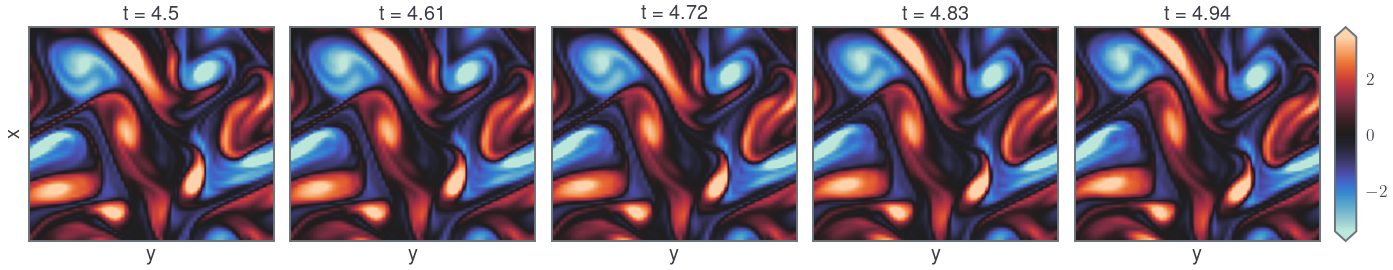

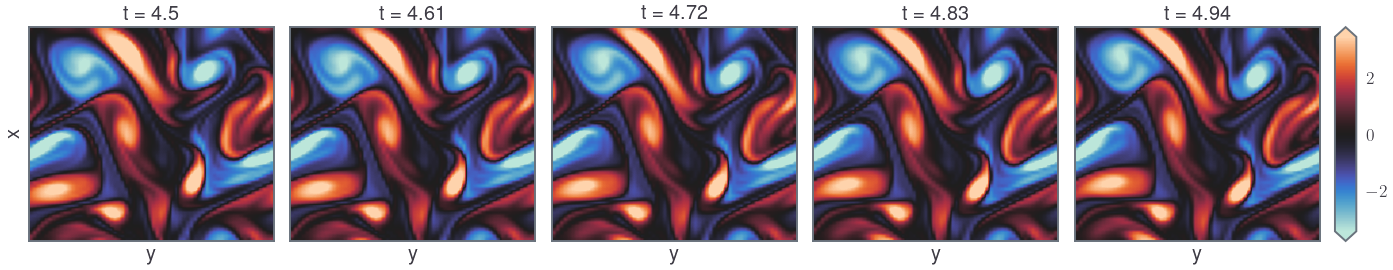

In [20]:
idx = np.random.randint(0, Ntest)
plot_contour_trajectory(preds[idx], num_snapshots=5, T_start=4.5, dt=5.5/100)
plot_contour_trajectory(gt_solns[idx], num_snapshots=5, T_start=4.5, dt=5.5/100)